<a href="https://colab.research.google.com/github/anushaharikrishnan/FaceMaskDetection/blob/main/FACEMASKDETECTIONROUGH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import os
import zipfile
import random
import tensorflow as tf
import shutil
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
from os import getcwd

In [5]:
print(len(os.listdir('/content/drive/MyDrive/Face Mask Detection/dataset/with mask')))
print(len(os.listdir('/content/drive/MyDrive/Face Mask Detection/dataset/without mask')))

690
686


In [6]:
try:
  os.mkdir('/tmp/withmask-or-withoutmask')
  os.mkdir('/tmp/withmask-or-withoutmask/training')
  os.mkdir('/tmp/withmask-or-withoutmask/testing')
  os.mkdir('/tmp/withmask-or-withoutmask/training/withmask')
  os.mkdir('/tmp/withmask-or-withoutmask/training/withoutmask')
  os.mkdir('/tmp/withmask-or-withoutmask/testing/withmask')
  os.mkdir('/tmp/withmask-or-withoutmask/testing/withoutmask')

except OSError:
  pass

In [7]:
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
  files = []
  for filename in os.listdir(SOURCE):
        file = SOURCE + filename
        if os.path.getsize(file) > 0:
            files.append(filename)
        else:
            print(filename + " is zero length, so ignoring.")
  training_length = int(len(files) * SPLIT_SIZE)
  testing_length = int(len(files) - training_length)
  shuffled_set = random.sample(files, len(files))
  training_set = shuffled_set[0:training_length]
  testing_set = shuffled_set[-testing_length:]
  
  for filename in training_set:
    this_file = SOURCE + filename
    destination = TRAINING + filename
    copyfile(this_file, destination)
  for filename in testing_set:
    this_file = SOURCE + filename
    destination = TESTING + filename
    copyfile(this_file, destination)



MASK_SOURCE_DIR="/content/drive/MyDrive/Face Mask Detection/dataset/with mask/"
TRAINING_MASK_DIR="/tmp/withmask-or-withoutmask/training/withmask/"
TESTING_MASK_DIR="/tmp/withmask-or-withoutmask/testing/withmask/"
WITHOUTMASK_SOURCE_DIR="/content/drive/MyDrive/Face Mask Detection/dataset/without mask/"
TRAINING_WITHOUTMASK_DIR="/tmp/withmask-or-withoutmask/training/withoutmask/"
TESTING_WITHOUTMASK_DIR="/tmp/withmask-or-withoutmask/testing/withoutmask/"

split_size = .7

split_data(MASK_SOURCE_DIR,TRAINING_MASK_DIR,TESTING_MASK_DIR,split_size)
split_data(WITHOUTMASK_SOURCE_DIR,TRAINING_WITHOUTMASK_DIR,TESTING_WITHOUTMASK_DIR,split_size)

In [9]:
print(len(os.listdir('/tmp/withmask-or-withoutmask/training/withmask/')))
print(len(os.listdir('/tmp/withmask-or-withoutmask/testing/withmask/')))
print(len(os.listdir('/tmp/withmask-or-withoutmask/training/withoutmask/')))
print(len(os.listdir('/tmp/withmask-or-withoutmask/testing/withoutmask/')))

train_withmask_fnames=os.listdir(TRAINING_MASK_DIR)
train_withoutmask_fnames=os.listdir(TRAINING_WITHOUTMASK_DIR)
test_withmask_fnames=os.listdir(TESTING_MASK_DIR)
test_withoutmask_fnames=os.listdir(TESTING_WITHOUTMASK_DIR)

print(train_withmask_fnames[:10])
print(train_withoutmask_fnames[:10])
print(test_withmask_fnames[:10])
print(test_withoutmask_fnames[:10])

482
208
480
206
['augmented_image_247.jpg', '330-with-mask.jpg', '13-with-mask.jpg', '311-with-mask.jpg', '221-with-mask.jpg', '467-with-mask.jpg', 'augmented_image_109.jpg', 'augmented_image_111.jpg', '334-with-mask.jpg', 'augmented_image_243.jpg']
['13.jpg', 'augmented_image_229.jpg', '287.jpg', 'augmented_image_142.jpg', 'augmented_image_109.jpg', '170.jpg', '107.jpg', '295.jpg', 'augmented_image_165.jpg', 'augmented_image_312.jpg']
['386-with-mask.jpg', '183-with-mask.jpg', '318-with-mask.jpg', 'augmented_image_6.jpg', 'augmented_image_142.jpg', '235-with-mask.jpg', '45-with-mask.jpg', '241-with-mask.jpg', 'augmented_image_147.jpg', '233-with-mask.jpg']
['57.jpg', 'augmented_image_275.jpg', 'augmented_image_111.jpg', '250.jpg', 'augmented_image_307.jpg', '388.jpg', 'augmented_image_243.jpg', '221.jpg', '399.jpg', 'augmented_image_147.jpg']


In [10]:
%matplotlib inline

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

pic_index = 0 # Index for iterating over images

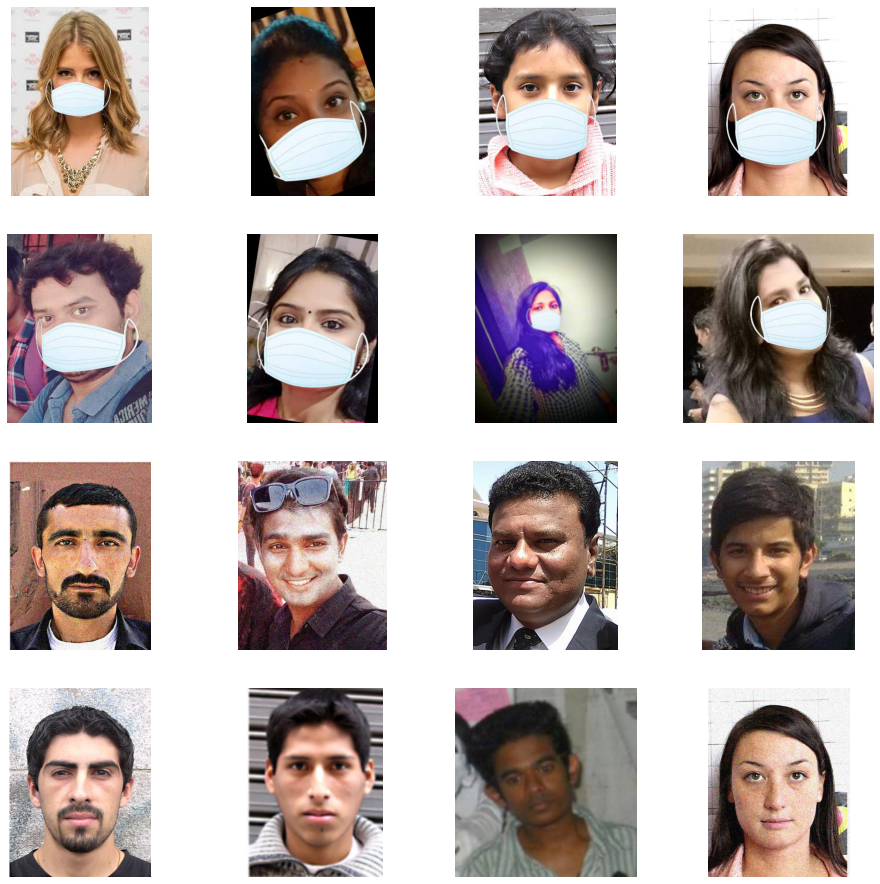

In [12]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

pic_index+=8

next_cat_pix = [os.path.join(TRAINING_MASK_DIR, fname) 
                for fname in train_withmask_fnames[ pic_index-8:pic_index] 
               ]

next_dog_pix = [os.path.join(TRAINING_WITHOUTMASK_DIR, fname) 
                for fname in train_withoutmask_fnames[ pic_index-8:pic_index]
               ]

for i, img_path in enumerate(next_cat_pix+next_dog_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

In [13]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>DESIRED_ACCURACY):
      print("\nReached 99.9% accuracy so cancelling training!")
      self.model.stop_training = True

callbacks = myCallback()


model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(300, 300, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])


model.compile(optimizer=RMSprop(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 298, 298, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 149, 149, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 147, 147, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 73, 73, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 71, 71, 128)       73856     
_________________________________________________________________
flatten (Flatten)            (None, 645248)            0         
_________________________________________________________________
dense (Dense)                (None, 512)               3

In [14]:
TRAINING_DIR = "/tmp/withmask-or-withoutmask/training/"
train_datagen = ImageDataGenerator(rescale=1.0/255.,rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    batch_size=50,
                                                    class_mode='binary',
                                                    target_size=(300, 300))


VALIDATION_DIR = "/tmp/withmask-or-withoutmask/testing/"
validation_datagen = ImageDataGenerator(rescale=1.0/255.,
                                        rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                              batch_size=50,
                                                              class_mode='binary',
                                                              target_size=(300, 300))

Found 962 images belonging to 2 classes.
Found 414 images belonging to 2 classes.


In [ ]:
checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)



history = model.fit(train_generator,
                              epochs=15,
                              verbose=1,
                              validation_data=validation_generator,
                    callbacks=[cp_callback])

Epoch 1/15
25/25 [==============================] - 29s 1s/step - loss: 0.0195 - accuracy: 0.9927 - val_loss: 0.0340 - val_accuracy: 0.9928

Epoch 00001: saving model to training_1/cp.ckpt
Epoch 2/15
25/25 [==============================] - 30s 1s/step - loss: 0.0458 - accuracy: 0.9879 - val_loss: 0.0168 - val_accuracy: 0.9928

Epoch 00002: saving model to training_1/cp.ckpt
Epoch 3/15
25/25 [==============================] - 30s 1s/step - loss: 0.0095 - accuracy: 0.9960 - val_loss: 0.0021 - val_accuracy: 1.0000

Epoch 00003: saving model to training_1/cp.ckpt
Epoch 4/15
25/25 [==============================] - 31s 1s/step - loss: 0.0783 - accuracy: 0.9806 - val_loss: 0.0077 - val_accuracy: 1.0000

Epoch 00004: saving model to training_1/cp.ckpt
Epoch 5/15
25/25 [==============================] - 30s 1s/step - loss: 0.0153 - accuracy: 0.9943 - val_loss: 0.0012 - val_accuracy: 1.0000

Epoch 00005: saving model to training_1/cp.ckpt
Epoch 6/15
25/25 [==============================] - 29s

<Figure size 432x288 with 0 Axes>

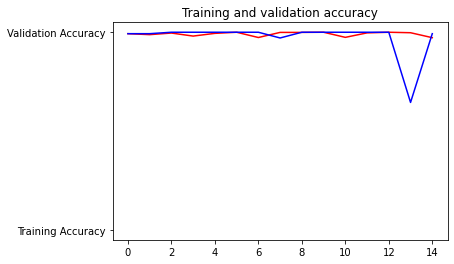

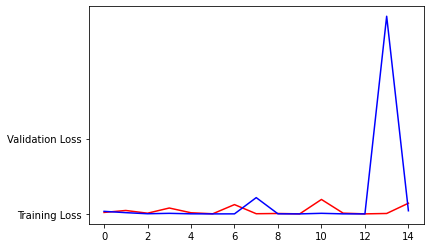

<Figure size 432x288 with 0 Axes>

In [ ]:
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.figure()


# Desired output. Charts with training and validation metrics. No crash :)

In [ ]:
# Here's a codeblock just for fun. You should be able to upload an image here 
# and have it classified without crashing
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(150, 150))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(classes[0])
  if classes[0]>0.5:
    print(fn + " is a with mask")
  else:
    print(fn + " is without mask")


Saving images.jpeg to images.jpeg
[0.]
images.jpeg is without mask
